In [1]:
from pathlib import Path
from ROAR.utilities_module.data_structures_models import Transform, Location
import numpy as np
from typing import Tuple, Optional
import cv2
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:

class Map:
    def __init__(self,
                 x_offset: float, y_offset: float, x_scale: float, y_scale: float,
                 x_width: int = 5000, y_height: int = 5000, buffer: int = 100,
                 name: str = "map"
                 ):
        self.name = name
        self.x_offset = x_offset
        self.y_offset = y_offset
        self.x_scale = x_scale
        self.y_scale = y_scale
        self.x_width = x_width
        self.y_height = y_height
        self.buffer = buffer
        self.map = np.zeros(shape=(self.y_height, self.x_width))

    def world_loc_to_occu_map_coord(self, loc: Location) -> Tuple[int, int]:
        """
        Takes in a coordinate in the world reference frame and transform it into the occupancy map coordinate by
        applying the equation
        `int( (WORLD + OFFSET ) * SCALE)`

        Args:
            loc:

        Returns:

        """
        x = int((loc.x + self.x_offset) * self.x_scale) + self.buffer
        y = int((loc.z + self.y_offset) * self.y_scale) + self.buffer
        return x, y

    def world_arr_to_occu_map(self, arr: np.ndarray) -> np.ndarray:
        xs = ((arr[:, 0] + self.x_offset) * self.x_scale + self.buffer).astype(int)
        ys = ((arr[:, 1] + self.y_offset) * self.y_scale + self.buffer).astype(int)
        return np.array([xs, ys]).T

    def update(self, points: np.ndarray, val=1) -> int:
        """

        Args:
            val: value to update those points to
            points: points is a 2D numpy array consist of X and Z coordinates

        Returns:
            number of points updated
        """
        points = self.world_arr_to_occu_map(points)
        self.map[points[:, 1], points[:, 0]] = val
        return len(points)

    def visualize(self, dsize: Optional[Tuple] = None):
        img = self.map.copy()
        if dsize:
            img = cv2.resize(img, dsize=dsize)
        plt.imshow(img,cmap='gray')
        plt.show()
#         cv2.imshow(self.name, img)

    @staticmethod
    def moving_average(a, n=3) :
        ret_x = np.cumsum(a[:, 0], dtype=float)
        ret_z = np.cumsum(a[:, 1], dtype=float)

        ret_x[n:] = ret_x[n:] - ret_x[:-n]
        ret_z[n:] = ret_z[n:] - ret_z[:-n]

        ret_x = ret_x[n - 1:] / n
        ret_z = ret_z[n - 1:] / n

        return np.array([ret_x, ret_z]).T

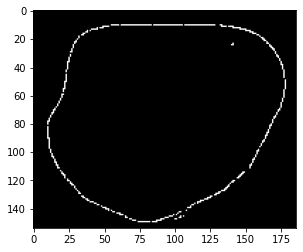

In [31]:
waypoints = []
waypoints_arr = []
# debug waypoint following
f = Path("transforms_1.txt").open('r')
for line in f.readlines():
    x, y, z = line.split(",")
    x, y, z = float(x), float(y), float(z)
    l = Location(x=x, y=y, z=z)
    waypoints.append(Transform(location=l))
    waypoints_arr.append([x, z])
waypoints_arr = np.array(waypoints_arr)

buffer = 10
x_scale = 20
y_scale = 20

x_offset = abs(min(waypoints_arr[:, 0]))
y_offset = abs(min(waypoints_arr[:, 1]))

width = int((max(waypoints_arr[:, 0]) - min(waypoints_arr[:, 0])) * x_scale + x_offset + buffer)
height = int((max(waypoints_arr[:, 1]) - min(waypoints_arr[:, 1])) * y_scale + y_offset + buffer)
m = Map(x_offset=x_offset, y_offset=y_offset, x_scale=20, y_scale=20,
          x_width=width, y_height=height, buffer=buffer)
m.update(waypoints_arr)
m.visualize()

In [43]:
def moving_average(a, n=3) :
    ret_x = np.cumsum(a[:, 0], dtype=float)
    ret_z = np.cumsum(a[:, 1], dtype=float)
    
    ret_x[n:] = ret_x[n:] - ret_x[:-n]
    ret_z[n:] = ret_z[n:] - ret_z[:-n]
    
    ret_x = ret_x[n - 1:] / n
    ret_z = ret_z[n - 1:] / n

    return np.array([ret_x, ret_z]).T

(2613, 2) (2594, 2)


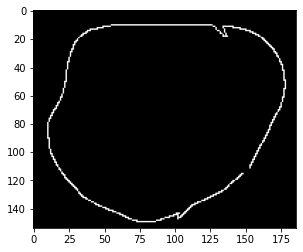

In [47]:
waypoints_arr2 = moving_average(waypoints_arr, 20)

print(waypoints_arr.shape, waypoints_arr2.shape)
buffer = 10
x_scale = 20
y_scale = 20

x_offset = abs(min(waypoints_arr[:, 0]))
y_offset = abs(min(waypoints_arr[:, 1]))

width = int((max(waypoints_arr[:, 0]) - min(waypoints_arr[:, 0])) * x_scale + x_offset + buffer)
height = int((max(waypoints_arr[:, 1]) - min(waypoints_arr[:, 1])) * y_scale + y_offset + buffer)
m = Map(x_offset=x_offset, y_offset=y_offset, x_scale=20, y_scale=20,
          x_width=width, y_height=height, buffer=buffer)
m.update(waypoints_arr2)
m.visualize()

# Filter out outliers

In [3]:
def filter_outlier(track, min_D=0, max_D=0.2, max_num_skip_threshold=100):
    filtered = []
    i = 1

    max_diff = 0
    min_diff = 100
    max_num_points_skipped = 0
    num_points_skipped = 0
    filtered.append(waypoints_arr[0])
    for i in range(1, len(waypoints_arr)):
        x2, z2 = waypoints_arr[i]
        x1, z1 = filtered[-1]
        diff_x, diff_z = abs(x2 - x1), abs(z2 - z1)
        diff_z
        if min_D < diff_x < max_D and min_D < diff_z < max_D:
            filtered.append([x2, z2])
            num_points_skipped = 0
        else:
            num_points_skipped += 1

        max_num_points_skipped = max(num_points_skipped, max_num_points_skipped)

    filtered = np.array(filtered)
    if max_num_points_skipped > max_num_skip_threshold:
        print("WARNING: possibly bad map")
    return filtered

In [4]:
waypoints = []
waypoints_arr = []
# debug waypoint following
f = Path("transforms_1.txt").open('r')
for line in f.readlines():
    x, y, z = line.split(",")
    x, y, z = float(x), float(y), float(z)
    l = Location(x=x, y=y, z=z)
    waypoints.append(Transform(location=l))
    waypoints_arr.append([x, z])
waypoints_arr = np.array(waypoints_arr)

filtered = filter_outlier(waypoints_arr, min_D=0, max_D=0.2, max_num_skip_threshold=100)

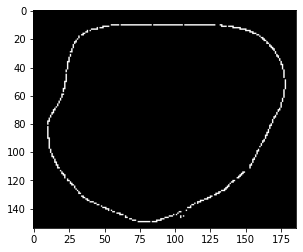

In [5]:
buffer = 10
x_scale = 20
y_scale = 20
x_offset = abs(min(filtered[:, 0]))
y_offset = abs(min(filtered[:, 1]))
width = int((max(filtered[:, 0]) - min(filtered[:, 0])) * x_scale + x_offset + buffer)
height = int((max(filtered[:, 1]) - min(filtered[:, 1])) * y_scale + y_offset + buffer)

m = Map(x_offset=x_offset, y_offset=y_offset, x_scale=20, y_scale=20,
        x_width=width, y_height=height, buffer=buffer)
m.update(filtered)
m.visualize()